In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import scipy.special as sps
import urllib as ul
import requests
from datetime import datetime, date, time

# Rainfall intervalometer: Theory and data processing

The rainfall intervalometer is a very simple instrument. Basically, it registers the times when raindrops fall on a small drum. If you want to build this instrument, please have a look at: 
https://github.com/nvandegiesen/Intervalometer/wiki/Intervalometer.
Here, we concentrate on the underlying theory and on how to convert arrival times to rainfall rates.

## Theory

You can skip the theory if you are not familiar with integral calculus or the Gamma function. We will end up with a simple polynomial that describes the relation between the number of drops measured per time interval and the rainfall rate. This will be sufficient to process measured date. 

Basic idea is to first calculate what the arrival rates are as a function of rainfall rate according to:
\begin{equation} 
\rho_A^* (\Lambda)   = \frac{\alpha N_0}{\Lambda^ {(\beta +1)}} \Gamma({\beta+1, D_{min} \Lambda})\ \  
\label((Eq. 1)
\end{equation}

In which:

\begin{align}
\Gamma(a,x) &: Upper\ incomplete\ Gamma\ function\\
\rho_A^* (\Lambda) &: Arrival\ rate\ (m^{-2} s^{-1}) (measured)\\
\Lambda &: Constant\ related\ to\ rainfall\ rate\ R\ (mm/h)\ according\ to\ \Lambda =4.10 R^{-0.210}\\
N_0 &: Constant,\ here\ taken\ as\ N_0=8000\ (-)\\
\alpha &: Constant\ associated\ with\ terminal\ velocity,\ here\ taken\ as\ \alpha=3.25\ m\ s^{-1}\ mm^{-\beta}\\
\beta &: Exponent\ associated\ with\ terminal\ velocity,\ here\ taken\ as\ \beta=0.762\\
D_{min} &: Minimum\ detectable\ dropsize\ diameter,\ here\ taken\ as\ D_{min}=0.8\ mm
\end{align}

Eq. 1 can be derived from the emprical relations found in 1948 by [Marshall & Palmer](https://doi.org/10.1175/1520-0469%281948%29005%3C0165:TDORWS%3E2.0.CO;2), shown in Figure 1 below, taken from [Uijlenhoet & Stricker, 1999](https://doi.org/10.1016/S0022-1694%2899%2900032-3).

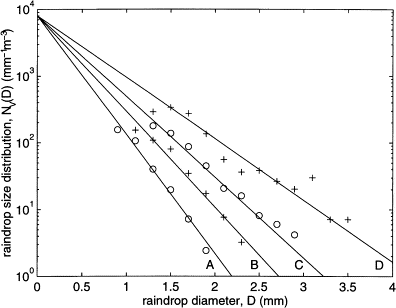 
 <p style="text-align: center;">*Figure 1: Probability density of drops per cubic meter of air of certain size for four rainfall intensities (1.0mm/h, 2.8mm/h, 6.3mm/h, 23.0mm/h).*</p>

We see that:

\begin{equation} 
N_V(D) = N_0 exp(-\Lambda * D)\ \ \label((Eq. 2)
\end{equation} 


When we, as Marshall and Palmer did, assume that a drop falls with a terminal velocity:

\begin{equation} 
v(D) = \alpha D^{\beta}=3.25D^{0.762}\ \ \label((Eq. 3)$$
\end{equation} 

then the probability density of drops falling per second on one square meter of ground surface is:

\begin{equation} 
N_A = \alpha N_{0} D^{\beta} exp(-\Lambda D)\ \ 
\label((Eq. 4)
\end{equation} 

If we want to know the total number of drops falling per second on one square meter, then we have to integrate over all possible raindrop diameters:

\begin{equation} 
\rho_A = \alpha N_0 \int_{0}^{\infty} D^{\beta} exp(-\Lambda) dD\ \ 
\notag\\
\rho_A = \frac{\alpha N_0}{\Lambda^ {(\beta +1)}} \Gamma({\beta+1})\ \ 
\label((Eq. 5)
\end{equation} 

Unfortunately, due to the limited sensitivity of the intervalometer, we can only measure raindrops from a certain diameter upwards ($D_{min}$) so the measured arrival rate becomes:

\begin{equation} 
\rho_A^* = \alpha N_0 \int_{D_{min}}^{\infty} D^{\beta} exp(-\Lambda) dD\ \ 
\notag\\
\rho_A^* = \frac{\alpha N_0}{\Lambda^ {(\beta +1)}} \Gamma({\beta+1, D_{min} \Lambda})\ \ 
\label((Eq. 1)
\end{equation} 

which can readily be calculated in Python.  

One can find many parameterizations in the literature, both for $\Lambda$ and for the terminal velocity (Eq. 3). A very good overview is given by [Uijlenhoet & Stricker, 1999](https://doi.org/10.1016/S0022-1694%2899%2900032-3), which also consolidates many of the different possible combinations.

We use the following parameters, which can be changed if needed. $D_{min}$ may vary depending on the sensor used for the intervalometer. $D_{min}$ can also be seen as an effective parameter as small drops falling in the middle of the drum will generate a similar signal strength as a larger drop near the edge.

In [2]:
# Constants
alpha = 3.25   # (m/s)
beta = 0.762   # (-)
N0 = 8000     # (-)
Dmin = 0.8   # (mm)

In [3]:
# Forward model (see Eq. 1), calculates arrival rates for rainfall rates between 0 and 200 mm/h
d = 0.1 #Rainfall intensity increment (mm/h)
R = d  #Rainfall intensity (mm/h)

nr = 2000     #Number of points in forward model
fw = np.zeros((nr,2))   #Values forward model

for i in range(1,nr):
    R = i * d    #Calculate rainfall intensity
    Lambda = 4.1 * R ** -0.21    #Calculate Lambda
    pre1 = alpha*N0/(Lambda**(beta+1)) 
    pre2 = sps.gamma(beta+1)
    rho = pre1 * pre2 * sps.gammaincc((beta+1),Dmin*Lambda) #Note: gammaincc is normalized wrt gamma(x)
    fw[i,0]=rho   #Arrival rate (1/s*m^2)
    fw[i,1]=R     #Rainfall rate (mm/h)



Text(0,0.5,'Rainfall rate (mm/h)')

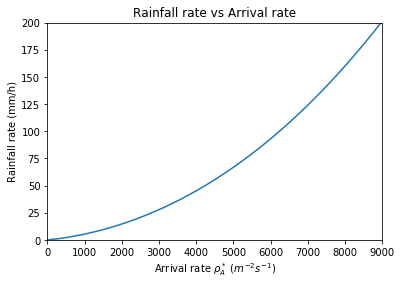

In [4]:
# Plot inverted results (rainfall rate as function of arrival rate) 
plt.plot(fw[0:nr,0],fw[0:nr,1])
plt.axis([0,9000,0,200])
plt.title(r'Rainfall rate vs Arrival rate')
plt.xlabel(r'Arrival rate $\rho_A^*\ (m^{-2}s^{-1}$)')
plt.ylabel('Rainfall rate (mm/h)')


We have now calculated the arrival rate as function of rainfall rate,  whereas we need to know the rainfall rate as function of the measured arrival rate. Although the inverse of the upper incomplete Gamma function is available in Python, we prefer to use a polynomial approximation for its ease-of-use. We fit a 3rd order polynomial through this curve. The polynomial is forced through (0,0), which, strictly speaking, need not be true because there may be very light rainfall with all drops below the minimal detectable dropsize.

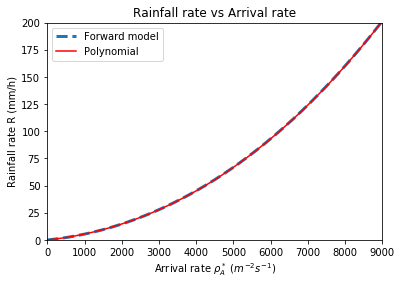

In [5]:
weight=np.zeros(nr)+1  #Equal weights to all points
weight[0]=10000        #Huge weight to (0,0)

fit=np.polyfit(fw[0:nr,0],fw[0:nr,1],3,w=weight)   #Fit 3rd order polynomial

y = np.polyval(fit,fw[0:nr,0])     #Calculate values of polynomial for given arrival rates

#Plot results
plt.plot(fw[0:nr,0],fw[0:nr,1], label='Forward model', linewidth=3, linestyle='--')
plt.plot(fw[0:nr,0],y, label='Polynomial', color='red')
plt.axis([0,9000,0,200])
plt.title(r'Rainfall rate vs Arrival rate')
plt.xlabel(r'Arrival rate $\rho_A^*\ (m^{-2}s^{-1}$)')
plt.ylabel('Rainfall rate R (mm/h)')
plt.legend()



The correlation coefficient between the polynomial and real curve is almost equal to one:

In [6]:
corr=np.corrcoef(fw[0:nr,1],y)
(corr[0,1])**2

0.9999998803855714

We now store the coefficients of the polynomial in a simple text file for later use, together with the constants used.


In [7]:
poly = open('polyconstants.txt','w') 
 
poly.write('alpha: '+str(alpha)+'\n')
poly.write('beta: '+str(beta)+'\n')
poly.write('coeffs: '+str(fit))

poly.close() 

file = open('polyconstants.txt','r') 
print(file.read())

alpha: 3.25
beta: 0.762
coeffs: [ 3.48030475e-11  1.75845637e-06  3.70090706e-03 -4.20322042e-08]


## Data processing

In [8]:
# Note: If your data file is already stored locally, comment out lines below
# Copy remote file to local file
file_name='http://iahs-icwrs.org/ival0998.txt'
response = requests.get(file_name)     # Get remote file
file_content = response.text           # Copy file content into variable

local_file='temp.txt'      # Temporary file to stire data locally

fh = open("temp.txt", "w")
fh.write(file_content)
fh.close
# Note: If your data file is already stored locally, comment out lines above

# Open local file and split into time stamps and interval times
read_file = open('temp.txt','r')
content= read_file.readlines()

first_t = True            # Set flag for first timestamp
old_millis = 0            # Zero milliseconds at start

for line in content:
  if line[0] == 't':       # timestamp
    first_t = False       # Reset flag first timestamp
    
    ftime = line.split(',')     # file time
    millis = ftime[7].strip('\n')    # Extract milliseconds without line return 
    
    rdate=datetime(int(ftime[1]), int(ftime[2]), int(ftime[3]), 
                   int(ftime[4]), int(ftime[5]), int(ftime[6]))     # Date & time from timestamp
    
    print(rdate)
    
  elif not first_t:        # Consider times only after first time stamp
    print('ms')          # time

    

2018-05-18 08:38:55
2018-05-18 09:08:55
2018-05-18 09:38:55
2018-05-18 10:08:55
2018-05-18 10:38:55
2018-05-18 11:08:55
2018-05-18 11:38:55
2018-05-18 12:08:55
2018-05-18 12:38:55
2018-05-18 13:08:55
2018-05-18 13:38:55
2018-05-18 14:08:55
2018-05-18 14:38:55
2018-05-18 15:08:55
2018-05-18 15:38:55
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
m

ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
ms
m

In [9]:
# 1 Check span during which logger was active

# 2 Extract millisecond intervals
